# Recurrant Neural Network 
The Recurrent neural network implementation is based on using LSTM cells, with peepholeconnections. he  model  has  2  layers  with  LSTM  cells.   It  contains  200  neurons,  usesa  learning  rate  of  0.001,  batch  size  of  300,  with  an  activation  of  sigmoid.   We  use  a  lossfunction  of  mean  squared  error,  and  an  Adam  optimizer  to  train  the  LSTM  model  onnormalized  outputs.  We  use  7  features,  and  try  to  predict  the  raw  return  over  10  daysusing data from the last 2 instance a stock was seen. 

In [70]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [10]:
#Load market data
market_train_df = pickle.load(open('Market_train',"rb"))
news_train_df = pickle.load(open('News_train-002', 'rb'))

In [11]:
market_train_df.shape

(4072956, 16)

In [12]:
news_train_df.shape

(9328750, 35)

In [13]:
#general pre-processing, similar to all the other models
def preprocess_data(mkt_train_df, news_train_df):
    mkt_train_df['time'] = mkt_train_df['time'].dt.date
    news_train_df['time'] = news_train_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_train_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_train_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_train_df.drop(irrelevantColumns, axis=1, inplace=True)
    market_train_df.drop(['assetName'], axis=1, inplace=True)
    modifiednews = news_train_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_train_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    return merged

In [14]:
#Normalize labels
def normalize(Y):
    min_v = Y.min()
    max_v = Y.max()
    Y = Y-min_v
    denom = max_v-min_v
    Y = Y/denom
    return Y

In [15]:
#Preprocess data and get labels
X = preprocess_data(market_train_df, news_train_df)
y = X['returnsOpenNextMktres10']
X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)
y.head()


NameError: name 'Y' is not defined

In [16]:
#Normalize y
y = normalize(y)

In [18]:
#Get all Features
X_new = X[['assetCode','close','open','sentimentClass','sentimentNegative','sentimentNeutral','sentimentPositive']]
X_new = pd.concat((X_new,y), axis = 1)
X_new.fillna(0)

,assetCode,close,open,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,returnsOpenNextMktres10
0,A.N,32.19,32.17,0.500000,0.080418,0.568264,0.351318,0.123476
1,AAI.N,11.12,11.08,0.250000,0.138128,0.412758,0.449114,0.123476
2,AAP.N,37.51,37.99,0.000000,0.000000,0.000000,0.000000,0.123475
3,AAPL.O,84.74,86.23,0.000000,0.000000,0.000000,0.000000,0.123473
4,ABB.N,18.02,18.01,0.000000,0.000000,0.000000,0.000000,0.123472
5,ABC.N,52.37,52.40,0.000000,0.000000,0.000000,0.000000,0.123478
6,ABD.N,23.63,24.13,0.000000,0.000000,0.000000,0.000000,0.123469
7,ABM.N,26.19,25.90,0.000000,0.000000,0.000000,0.000000,0.123475
8,ABT.N,52.87,52.50,1.000000,0.181860,0.363647,0.454493,0.123474
9,ABV.N,52.46,52.10,0.000000,0.000000,0.000000,0.000000,0.123474


In [19]:
#Get labels
labels = X_new.assetCode
labels = pd.get_dummies(labels)
#Convert label to argmax
label_n = labels.values
#Convert to integer values
label_n = np.argmax(label_n, axis= 1)
#Convert to DF
label_pd = pd.DataFrame(label_n ,columns = ['assetCode'])

In [20]:
#Concat integer mapping of assetcodes
X_temp = X_new.drop(labels=['assetCode'], axis=1)
X_final = pd.concat((label_pd,X_temp), axis=1)

In [21]:
#Get a copy of full data set
df_stock = X_final.copy()  #Get values for stock 
df_stock.shape

(4072956, 8)

In [50]:
#Return train, test, and validation based on how many sequences you want
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    valid_set_size_percentage = 5
    test_set_size_percentage = 50
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    m = y_train.shape[0]
    y_train = np.reshape(y_train[:,-1] , [m,1])
  
    
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    m = y_valid.shape[0]
    y_valid = np.reshape(y_valid[:,-1] , [m,1])
    
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    m = y_test.shape[0]
    y_test = np.reshape(y_test[:,-1], [m,1])
  
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [54]:
#Get train test validate split
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock, 3)

/home/atharvachalke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [55]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = 2
n_inputs = 8 
n_neurons = 150 
n_outputs = 1
n_layers = 1
learning_rate = 0.001
batch_size = 200
n_epochs = 20 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell if needed - we found LSTM to work better with the computation resources available
#USE LSTM
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                  activation=tf.nn.relu, use_peepholes = True) for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)


In [56]:
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
train_Loss = []
test_Loss = []

with tf.Session(config=config) as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        
        
        if iteration % int(2*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            train_Loss.append(mse_train)
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            test_Loss.append(mse_valid)
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
    
    
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    #y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 469.116394/483.556427
2.00 epochs: MSE train/valid = 0.003238/0.001019
4.00 epochs: MSE train/valid = 0.029104/0.000276
6.00 epochs: MSE train/valid = 0.012445/0.010944
8.00 epochs: MSE train/valid = 0.001146/0.000086
10.00 epochs: MSE train/valid = 0.000349/0.000250
12.00 epochs: MSE train/valid = 0.000156/0.000076
14.00 epochs: MSE train/valid = 0.000128/0.000123
16.00 epochs: MSE train/valid = 0.000002/0.000000
18.00 epochs: MSE train/valid = 0.000001/0.000000
20.00 epochs: MSE train/valid = 0.000001/0.000000


In [79]:
#Convert to array
test_Loss_ar = np.reshape(np.array(test_Loss) , [11,1])
train_Loss_ar = np.reshape(np.array(train_Loss), [11,1])

In [80]:
#Get epochs
epochs = np.reshape(np.linspace(0,20,11),[11,1])
print(epochs.shape)

(11, 1)


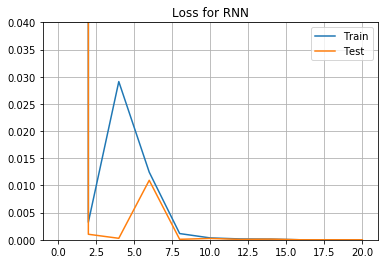

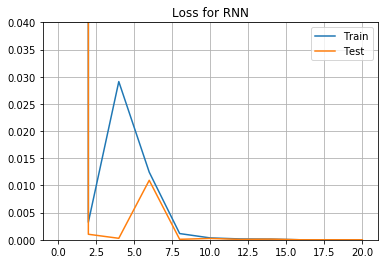

In [99]:
#Loss Plots for RNN
plt.figure()
plt.plot(epochs, train_Loss_ar, label='Train')
plt.grid()
plt.title("Loss for RNN")
plt.ylim(0,0.04)
plt.plot(epochs, test_Loss_ar, label = 'Test')
plt.legend()
plt.savefig("LossRNN")
plt.show()